* Error performing wm_overrideredirect *


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

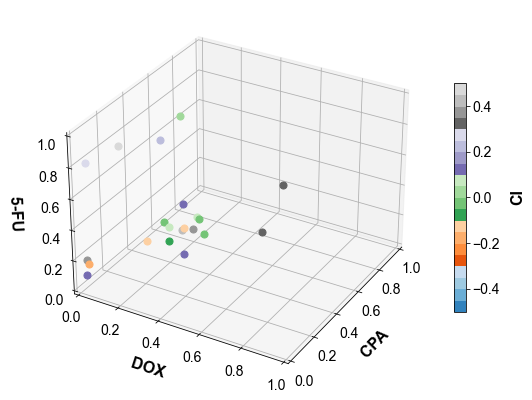

In [1]:
import PySimpleGUI as sg
import os.path
import cv2
import numpy as np
import json
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

from skimage import data, io, filters, transform
from skimage.morphology import closing, square
from skimage.filters import threshold_otsu, threshold_yen, threshold_triangle
from skimage.segmentation import clear_border
from skimage.morphology import closing, square

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


settings = {
    'folder' : '/Users/viprorok/Downloads/D11-3 Ctrl - Ctrl',
    'invert_flag' : True,
    'autocontrast_flag' : True,
    'scaling_factor': 12,       ### 6 for 100um and 12 for 300 um
    'rows' : 4,
    'columns' : 25,
    'radius' : 85,     ### [30 for 100 um] and [85 for 300um]
    'offset' : 10,
    'flag_100' : False,
    'flag_300' : True,
    'devices' : 1,
    'live_range' : [0.015, 0.09],
    'dead_range' : [0.08, 0.02],
    'hist_flag' : True,
    'ch_flag' : False,
    'dil_flag': True,
    'cv_threshold': 0.5,
    'synergy_flag': True
    }

boxes = []
cords = []  

image_bf_raw = 0
image_live_raw = 0 
image_dead_raw = 0 
image_bf = 0
image_live = 0
image_dead = 0
num_channels = 0
window =[]
figure_canvas_agg = None

flag_crop = False
img_file_flag = False
flag_grid = False
flag_seg = False
calc_flag = False



            
def load_settings(name):
    with open(name) as f:
        data = json.load(f)
    return data

def save_settings(name, fit_data):
    with open(name, 'w') as json_file:
        json.dump(fit_data, json_file)

def show_img(image_raw, name, scale):
    cv2.namedWindow(name, cv2.WINDOW_AUTOSIZE)  
    image_print = transform.resize(image_raw, (image_raw.shape[0]//scale, image_raw.shape[1]//scale))   
    cv2.imshow(name,image_print)
    
def on_mouse_crop(event, x, y, flags, params):
    global image_bf
    global image_live, image_dead
    global settings
    global flag_crop
    global boxes
    
    scaling_factor = settings['scaling_factor']
    
    #### defining the first coordinate of box using left button click of the mouse
    if event == cv2.EVENT_LBUTTONDOWN:
        sbox = [x, y]
        boxes.append(sbox)
    
    #### defining the second coordinate of box using left button  of the mouse and cropping of the image
    elif event == cv2.EVENT_LBUTTONUP:
        ebox = [x, y]
        boxes.append(ebox)
        
        #### cropping the images
        image_bf = crop(image_bf, boxes[0][1]*scaling_factor, boxes[1][1]*scaling_factor,
                        boxes[0][0]*scaling_factor, boxes[1][0]*scaling_factor)
        
        image_live = crop(image_live, boxes[0][1]*scaling_factor, boxes[1][1]*scaling_factor, 
                             boxes[0][0]*scaling_factor, boxes[1][0]*scaling_factor )
        
        image_dead = crop(image_dead, boxes[0][1]*scaling_factor, boxes[1][1]*scaling_factor, 
                             boxes[0][0]*scaling_factor, boxes[1][0]*scaling_factor )
        
        #### turning off the cropping loop function
        flag_crop = 0
        cv2.setMouseCallback('BF', nothing)
        
        #### show updated brightfield image
        show_img(image_bf, 'BF', scaling_factor)

def nothing(event, x, y, flags, params):
    pass

def automatic_brightness_and_contrast(image, clip_hist_percent=1):

    # Calculate grayscale histogram
    hist,bins = np.histogram(image.ravel(),512,range=[0,1])
    hist_size = len(hist)


    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index - 1] + float(hist[index]))
    
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size - 1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray) *255
    #beta = -minimum_gray * alpha
    beta = 0
    
    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)


def filelist(folder, ext):
    try:
        # Get list of files in folder
        file_list = os.listdir(folder)
    except:
        file_list = []
    fnames = [
        f
        for f in file_list
        if os.path.isfile(os.path.join(folder, f)) and f.lower().endswith((ext))
    ]
    return fnames

def crop(image_raw, x_min, x_max, y_min, y_max):
    image = image_raw[int(x_min):int(x_max), int(y_min):int(y_max)]
    return image


#### adding/removal of the region using the mouse left button click
def on_mouse_rem(event, x, y, flags, params):
    global cords
    global settings
    global image_bf

    radius = settings['radius']
    scaling_factor = settings['scaling_factor']
    #### flag for the addition(FALSE)/removal(TRUE) of the region
    flag = 0
    
    if event == cv2.EVENT_LBUTTONDOWN:
        #### search for the existing region containing the chosen pixel
        for i, cord in enumerate(cords):
            cent_x, cent_y = cord
            if (x*scaling_factor > cent_x - radius) and (x*scaling_factor < cent_x + radius):
                if (y*scaling_factor > cent_y - radius) and (y*scaling_factor < cent_y + radius):
                    #### region was found: delete the region from the list and skip the addition of the region
                    flag = 1
                    cords = np.delete(cords, i, axis=0)
                    #### show updated regions
                    image_bf_s = draw_regions(cords, image_bf)
                    show_img(image_bf_s, 'Segment', scaling_factor)
                    
        #### region was NOT found: add a new region with the coordinates of the chosen pixel
        if flag == 0:
            l = len(cords)
            cord = np.array([(x*scaling_factor, y*scaling_factor)])
            cords = np.append(cords, cord).reshape(l+1, 2)
            #### show updated regions
            image_bf_s = draw_regions(cords, image_bf)
            show_img(image_bf_s, 'Segment', scaling_factor)
            
#### defining the grid using 3 points (1-top left, 2-bottom left, 3-bottom right) of the grid corners
def on_mouse_grid(event, x, y, flags, params):
    global cords
    global image_bf
    global settings
    global flag_grid, flag_seg
    
    scaling_factor = settings['scaling_factor']
    radius = settings['radius']
    devices = settings['devices']
    columns = settings['columns']
    rows = settings['rows']
    
    #### add(FALSE)/remove(TRUE) point from the list
    #### to remove the point we need to left click on it once more time
    flag = 0
    
    if flag_grid == 1:
        if event == cv2.EVENT_LBUTTONDOWN:
            #### if the chosen pixel belongs to th already existing point - detete point
            for i, cord in enumerate(cords):
                cent_x, cent_y = cord
                if (x*scaling_factor > cent_x - radius) and (x*scaling_factor < cent_x + radius):
                    if (y*scaling_factor > cent_y - radius) and (y*scaling_factor < cent_y + radius):
                        flag = 1
                        cords = np.delete(cords, i, axis=0)
                        #### show updated regions
                        image_bf_s = draw_regions(cords, image_bf)
                        show_img(image_bf_s, 'Segment', scaling_factor)
                        
            
            #### add the point with the coordinates of the chosen pixel
            if flag == 0:
                l = len(cords)
                cord = np.array([(x*scaling_factor, y*scaling_factor)])
                cords = np.append(cords, cord).reshape(l+1, 2)
                #### if it was the THIRD point (all required coordinates have been chosen) - pass the function
                if ((len(cords) == 3) & (rows > 1)) & (devices == 1) :
                    
                    #### calculation of the coordinates of all the wells in the grid
                    cords = grid(cords[0], cords[1], cords[2], (0,0), rows, columns, devices)
                    flag_grid = 0
                    flag_seg = 1
                
                if ((len(cords) == 4) & (rows > 1)) & (devices > 1) :
                    
                    #### calculation of the coordinates of all the wells in the grid
                    cords = grid(cords[0], cords[1], cords[2], cords[3], rows, columns, devices)
                    flag_grid = 0
                    flag_seg = 1
                    
                if ((len(cords) == 3) & (rows == 1)) & (devices > 1) :
                    
                    #### calculation of the coordinates of all the wells in the grid
                    cords = grid_1ch(cords[0], cords[1], cords[2], columns, devices)
                    flag_grid = 0
                    flag_seg = 1
                    
                if ((len(cords)==2) & (rows == 1)) & (devices == 1):
                    
                    #### calculation of the coordinates of all the wells in the grid
                    cords = grid_1ch(cords[0], cords[1], (0,0), columns, devices)
                    flag_grid = 0
                    flag_seg = 1
                
                
                #### show updated regions

                image_bf_s = draw_regions(cords, image_bf)
                show_img(image_bf_s, 'Segment', scaling_factor)
                
#### defining of the coordinates of the wells using the grid
def grid(cord_1, cord_2, cord_3, cord_4, rows, columns, devices): 
    
    #### caclulation of the distances between the wells in the grid
    dy_rows = (cord_2[1] - cord_1[1])/(rows-1)
    dx_rows = (cord_2[0] - cord_1[0])/(rows-1)

    dy_columns = (cord_3[1] - cord_2[1])/(columns-1)
    dx_columns = (cord_3[0] - cord_2[0])/(columns-1)
    
    #### creation of 2D array of the coordinates of the wells
    wells = np.zeros((columns*devices,rows,2))
    wells[0][0] = cord_1
    wells[0][rows-1] = cord_2
    wells[columns-1][rows-1] = cord_3

    for i in range(columns):
        x = wells[0][0][0] + dx_columns*i
        y = wells[0][0][1] + dy_columns*i
        wells[i][0] = (x,y)

        for j in range(rows):
            x = wells[i][0][0] + dx_rows*j
            y = wells[i][0][1] + dy_rows*j
            wells[i][j] = (x,y)
    
    
    if (devices > 1):
        dy_devices = (cord_4[1] - cord_3[1])/(devices-1)
        dx_devices = (cord_4[0] - cord_3[0])/(devices-1)
        
        for k in range(devices-1):
                for i in range(columns):
                    x = wells[0][0][0] + dx_columns*i + dx_devices*(k+1)
                    y = wells[0][0][1] + dy_columns*i + dy_devices*(k+1)
                    wells[i+columns*(k+1)][0] = (x,y)

                    for j in range(rows):
                        x = wells[i+columns*(k+1)][0][0] + dx_rows*j 
                        y = wells[i+columns*(k+1)][0][1] + dy_rows*j
                        wells[i+columns*(k+1)][j] = (x,y)
            
    
    #### reshaping of 2D array to the list of the coordinates
    cords = np.reshape(wells,(-1,2))  
    cords.tolist()
    return cords

def grid_1ch(cord_1, cord_2, cord_3, columns, devices): 
    
    #### caclulation of the distances between the wells in the grid

    dy_columns = (cord_2[1] - cord_1[1])/(columns-1)
    dx_columns = (cord_2[0] - cord_1[0])/(columns-1)
    
    #### creation of 2D array of the coordinates of the wells
    wells = np.zeros((columns*devices,1,2))
    wells[0][0] = cord_1
    wells[columns-1][0] = cord_2

    for i in range(columns):
        x = wells[0][0][0] + dx_columns*i
        y = wells[0][0][1] + dy_columns*i
        wells[i][0] = (x,y)
        
    if (devices > 1):
        dy_devices = (cord_3[1] - cord_2[1])/(devices-1)
        dx_devices = (cord_3[0] - cord_2[0])/(devices-1)
        
        for k in range(devices-1):
            for i in range(columns):
                x = wells[0][0][0] + dx_columns*i + dx_devices*(k+1)
                y = wells[0][0][1] + dy_columns*i + dy_devices*(k+1)
                wells[i+columns*(k+1)][0] = (x,y)

    #### reshaping of 2D array to the list of the coordinates
    cords = np.reshape(wells,(-1,2))  
    cords.tolist()
    return cords


#### merging of the brightfield image and the defined regions
def draw_regions(cords, image):
    global settings
    global window
    radius = settings['radius']
    window['-SEG-'].update(len(cords))
    image_bf_s = image.copy()
    
    for cord in cords:
        cent_x, cent_y = cord
        image_bf_s = cv2.circle(image_bf_s, (int(cent_x), int(cent_y)), radius, [0], 5)
    return image_bf_s 


def ratio_viability(live_value, dead_value, live_range = [0.015, 0.09], dead_range = [0.08, 0.02], resolution = 0.01): #### ranges [c_0, c_100]
    value = live_value/dead_value
    
    step = int(100/resolution)
    live = np.linspace(live_range[0], live_range[1], num=step)
    dead = np.linspace(dead_range[0], dead_range[1], num=step)
    ratio = np.divide(live,dead)
    
    if (live_value < live_range[0]) and (dead_value < dead_range[0]):
        viability = -1
    else:
        index = -1
        #### search through the table data
        for i in range(step):
            if (ratio[i]-value) >= 0:
                index = i
                break

        viability = index/step*100

        if (index == -1) and (value < ratio[0]):
            viability = 0

        if (index == -1) and (value > ratio[step-1]):
            viability = 101 
    
    return viability



#### circular mask for intensity measurements of each well
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center >= radius
    return mask


#### calculation of the fluorescence intensities of the wells
def calc_fluo(regions, image, image_live, image_dead, num_channels):
    global settings
    radius = settings['radius']
    offset = settings['offset']
    
    radius_mask = radius + offset
    stats = []
    frames =[]
    
    
    if num_channels == 1:

        masked_img = image.copy()    

        thresh = threshold_yen(masked_img)

        for i, region in enumerate(regions):

            #### mask image inside circle
            x0, y0 = region

            # crop image to circle of interest
            x_low = int(round(x0, 0)) - radius_mask
            x_high = int(round(x0, 0)) + radius_mask
            y_low = int(round(y0, 0)) - radius_mask
            y_high = int(round(y0, 0)) + radius_mask

            cropped_img = masked_img[y_low:y_high, x_low:x_high]
            frames.append((cropped_img))

            mask = create_circular_mask(w=radius_mask*2, h=radius_mask*2, center=(radius_mask, radius_mask), radius=radius)

            total_num_pixels = np.sum(~mask)
            
            cropped_img[mask] = 0
            # count how many pixels in mask/circle
            intensity_gray = np.sum(cropped_img) / total_num_pixels
            
            bw = closing(cropped_img < thresh, square(2))
            cleared = clear_border(bw)

            tot_num_pixels = np.sum(~bw)
            area = (total_num_pixels - tot_num_pixels)/total_num_pixels

            stats.append((x0, y0, area, intensity_gray))
    
    
    
    if num_channels == 2:

        masked_img = image.copy()    
        masked_img_live = image_live.copy()

        thresh = threshold_yen(masked_img)

        for i, region in enumerate(regions):

            #### mask image inside circle
            x0, y0 = region

            # crop image to circle of interest
            x_low = int(round(x0, 0)) - radius_mask
            x_high = int(round(x0, 0)) + radius_mask
            y_low = int(round(y0, 0)) - radius_mask
            y_high = int(round(y0, 0)) + radius_mask

            cropped_img = masked_img[y_low:y_high, x_low:x_high]
            cropped_img_live = masked_img_live[y_low:y_high, x_low:x_high]
                        
            frames.append((cropped_img, cropped_img_live))

            mask = create_circular_mask(w=radius_mask*2, h=radius_mask*2, center=(radius_mask, radius_mask), radius=radius)

            total_num_pixels = np.sum(~mask)

            cropped_img[mask] = 0
            cropped_img_live[mask] = 0

            #### calculate sum intensity
            #intensity = np.sum(masked_img) / num_active_pixels  # scale just to get lower number to look at
            intensity_gray = np.sum(cropped_img) / total_num_pixels
            intensity_live = np.sum(cropped_img_live) / total_num_pixels

            # count how many pixels in mask/circle

            bw = closing(cropped_img < thresh, square(2))
            cleared = clear_border(bw)

            tot_num_pixels = np.sum(~bw)
            area = (total_num_pixels - tot_num_pixels)/total_num_pixels

        
            stats.append((x0, y0, area, intensity_gray, intensity_live))


    
    
    if num_channels >= 3:

        masked_img = image.copy()    
        masked_img_live = image_live.copy()
        masked_img_dead = image_dead.copy()

        thresh = threshold_yen(masked_img)

        for i, region in enumerate(regions):

            #### mask image inside circle
            x0, y0 = region

            # crop image to circle of interest
            x_low = int(round(x0, 0)) - radius_mask
            x_high = int(round(x0, 0)) + radius_mask
            y_low = int(round(y0, 0)) - radius_mask
            y_high = int(round(y0, 0)) + radius_mask

            cropped_img = masked_img[y_low:y_high, x_low:x_high]
            cropped_img_live = masked_img_live[y_low:y_high, x_low:x_high]
            cropped_img_dead = masked_img_dead[y_low:y_high, x_low:x_high]
            frames.append((cropped_img, cropped_img_live, cropped_img_dead))

            mask = create_circular_mask(w=radius_mask*2, h=radius_mask*2, center=(radius_mask, radius_mask), radius=radius)

            total_num_pixels = np.sum(~mask)

            cropped_img[mask] = 0
            cropped_img_live[mask] = 0
            cropped_img_dead[mask] = 0

            #### calculate sum intensity
            #intensity = np.sum(masked_img) / num_active_pixels  # scale just to get lower number to look at
            intensity_gray = np.sum(cropped_img) / total_num_pixels
            intensity_live = np.sum(cropped_img_live) / total_num_pixels
            intensity_dead = np.sum(cropped_img_dead) / total_num_pixels 

            # count how many pixels in mask/circle

            bw = closing(cropped_img < thresh, square(2))
            cleared = clear_border(bw)

            tot_num_pixels = np.sum(~bw)
            area = (total_num_pixels - tot_num_pixels)/total_num_pixels
            
            stats.append((x0, y0, area, intensity_gray, intensity_live, intensity_dead, intensity_live/intensity_dead, ratio_viability(intensity_live,intensity_dead, live_range = settings['live_range'], dead_range = settings['dead_range'])))

    return stats, frames


def plot_hist(data, bins, canvas):
    global figure_canvas_agg
    
    if figure_canvas_agg:
        figure_canvas_agg.get_tk_widget().forget()
        plt.close('all')

    figure, ax = plt.subplots()
    labels = []
    color_scheme = plt.cm.get_cmap('tab10')
    for i, dev in enumerate(data['device'].unique()):
        data[data.device == dev]['Viability'].plot.hist(density=True, ax=ax, bins = bins, color = color_scheme(i), alpha=0.5, rwidth=0.85)
        data[data.device == dev]['Viability'].plot.kde(ax=ax, legend=True, bw_method=1, color = color_scheme(i))
        labels.append('Device ' + str(i+1))

    ax.set_ylabel('Probability', fontsize = 14)
    ax.set_xlim(0,100)
    ax.set_xlabel('Cell viability', fontsize = 14)
    ax.legend(labels)
    
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    
    return figure

#Defining objective function (Hill equation)
def hill(c, e1, h, ec):
    return 1+np.divide(e1-1,np.power(np.divide(ec,c),h)+1) 

def norm_conc(x0, norm_bounds):
    try:
        norm_bounds_log = np.log10(norm_bounds)
        x0_log = np.log10(x0)
        x_scaled = (x0_log - min(norm_bounds_log))/(max(norm_bounds_log) - min(norm_bounds_log))
    except:
        x_scalled = []
    return x_scaled
    
def norm_conc_inverse(x, norm_bounds):
    norm_bounds_log = np.log10(norm_bounds)
    x_inverse = (x*(max(norm_bounds_log) - min(norm_bounds_log)))+min(norm_bounds_log)
    x_scaled = np.power(10,x_inverse)
    return x_scaled

def cell_viability(x, y, z, fit_x, fit_y, fit_z):
        
    cv_x = hill(x, fit_x[0], fit_x[1], fit_x[2])
    cv_y = hill(y, fit_y[0], fit_y[1], fit_y[2])
    cv_z = hill(z, fit_z[0], fit_z[1], fit_z[2])
   
    cv = cv_x*cv_y*cv_z
    return cv 

def norm_data_inverse(data_raw,fit_dict):
    data = data_raw.copy()
    data['conc0_inv'] = norm_conc_inverse(data['conc0'],fit_dict['bounds'][0])
    data['conc1_inv'] = norm_conc_inverse(data['conc1'],fit_dict['bounds'][1])
    data['conc2_inv'] = norm_conc_inverse(data['conc2'],fit_dict['bounds'][2])
    return data

def dilution(conc,stock, vol):
    v = round(vol*conc/stock,1)
    return v

def dil_table(data, stock, vol = 1000):
    data_dil = data.copy()
    data_dil['vol0'] = dilution(data_dil['conc0_inv'],stock[0],vol)
    data_dil['vol1'] = dilution(data_dil['conc1_inv'],stock[1],vol)
    data_dil['vol2'] = dilution(data_dil['conc2_inv'],stock[2],vol)
    data_dil['vol_media'] = vol - data_dil['vol0'] - data_dil['vol1']- data_dil['vol2']

    return data_dil

def plot_data(data, synergy, canvas):
    global figure_canvas_agg
    
    if figure_canvas_agg:
        figure_canvas_agg.get_tk_widget().forget()
        plt.close('all')
        
    fig = plt.figure(figsize = (10,7))
    ax = fig.add_subplot(projection='3d')
    
    parameters = {'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'font.family':'sans-serif',
              'font.sans-serif':['Arial']}
    plt.rcParams.update(parameters) 
    
    ax = plt.axes(projection='3d')
    cmap = plt.cm.tab20c
    norm = plt.Normalize(vmin=-0.5, vmax=0.5)

    
    for i in range(len(data.index)):
        x = data.iloc[i]['conc0']
        y = data.iloc[i]['conc1']
        z = data.iloc[i]['conc2']
        normalize = matplotlib.colors.Normalize(vmin=-0.5, vmax=0.5)
        
        if synergy:
            if not (np.isnan(data.iloc[i]['ci'])):
                col = data.iloc[i]['ci']
                p = ax.scatter3D(x, y, z, c=cmap(norm(col)), alpha = 1, s=50)
                
                               
        else:
            if data.iloc[i]['feas']:
                color = 'green'
            else:
                color = 'red'            
            if not(np.isnan(data.iloc[i]['ci'])):
                color = 'grey'
            ax.scatter3D(x, y, z, c=color, alpha = 0.5, s=50)
            
        

    ax.zaxis._axinfo['juggled'] = (1,2,0)
    ax.yaxis._axinfo['juggled'] = (0,1,2)
    #ax.set_title(title, fontsize=16)
    ax.xaxis._axinfo['label']['space_factor'] = 1

    ax.set_xlabel('DOX     ', fontsize=16,fontweight='bold', labelpad =10)
    ax.set_ylabel('CPA    ', fontsize=16,fontweight='bold', labelpad =10)
    ax.set_zlabel('5-FU    ', fontsize=16,fontweight='bold', labelpad =10)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.set_zlim(0,1)
    
    #ax.view_init(30, 45)
    #plt.draw()
    
    if synergy:
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.6, aspect=20)
        cbar.set_label("CI", fontsize=16, fontweight='bold', labelpad =10)
    
    figure_canvas_agg = FigureCanvasTkAgg(fig, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    
    return fig
 

def table_show(data, fit_dict, dil):
    
    features =  ['conc0_inv','conc1_inv', 'conc2_inv', 'ci','cv_theor']
    headings = ['DOX','CPA', '5-FU', 'CI','CV theor']
    buttons = [[sg.Checkbox('Dilutions', default=dil, key="-DIL-", enable_events=True)],
        [sg.Button('Synergy'),sg.Button('Save dataset'), sg.Button('Correct fit file'),sg.Button('Main menu'),sg.Button('Quit')]]

    if dil:
        data = dil_table(data, fit_dict['stock'])
        features =  ['conc0_inv','conc1_inv', 'conc2_inv', 'ci','cv_theor','vol0','vol1','vol2']
        headings = ['DOX','CPA', '5-FU', 'CI','CV theor','Vol DOX','Vol CPA','Vol 5-FU']
        buttons = [[sg.Text('Stocks', size = (55,1)),sg.In(fit_dict['stock'][0], size = (10,1), enable_events=True, key = '-STOCK0-'),sg.In(fit_dict['stock'][1], size = (10,1), enable_events=True, key = '-STOCK1-'),sg.In(fit_dict['stock'][2], size = (10,1), enable_events=True, key = '-STOCK2-')],
                   [sg.Checkbox('Dilutions', default=dil, key="-DIL-", enable_events=True)], 
                   [sg.Button('Synergy'),sg.Button('Save dataset'), sg.Button('Correct fit file'), sg.Button('Main menu'),sg.Button('Quit')]]

    header =  [[sg.Text(h, size=(10,1)) for h in headings]]

    rows = []
    
    for i in range(len(data)):
        row = [sg.Text(round(data.iloc[i][f],2), size=(10,1)) for f in features]
        rows.append(row)
  
    rows = [[sg.Column(rows, scrollable=True)]]
    layout = header + rows + buttons
    
    return layout
 



def main():
    global settings
    global img_file_flag, flag_crop
    global image_bf_raw, image_live_raw, image_dead_raw, image_bf, image_live, image_dead, num_channels
    global boxes, cords
    global flag_grid, flag_seg
    global window
    global calc_flag

    
    img_filename = ''
    csv_filename = ''
    d1_name = ''
    d3_name = ''
    data_name = ''
    fit_name = ''
    img_flag = 0
    text_channels = ''
    rotation = 0
    report_flag = False
    f_flag = False
    
    
    
    layout = [[sg.Button('Analysis of images')],     
                      [sg.Button('Relative cell viability'), sg.Button('Correct CV')],
                      [sg.Button('Synergy')],
                      [sg.Text()],
                      [sg.Button('Settings'),sg.Button('Quit')]]
    
    window = sg.Window('Main menu', layout)

    while True:
        event, values = window.read()

        if event == 'Quit' or event == sg.WIN_CLOSED :
            window.close()
            cv2.destroyAllWindows()
            break
        
        elif event == 'Main menu':
            window.close()
            cv2.destroyAllWindows()
            layout = [[sg.Button('Analysis of images')],     
                      [sg.Button('Relative cell viability'), sg.Button('Correct CV')],
                      [sg.Button('Synergy')],
                      [sg.Text()],
                      [sg.Button('Settings'),sg.Button('Quit')]]
            window = sg.Window('Main menu', layout)
        
        elif event == 'Analysis of images':
            window.close()
            cv2.destroyAllWindows()
            
            fnames = filelist(settings['folder'], ".tif")

            layout_files = [
                [
                    sg.Text("Image Folder"),
                    sg.In(settings['folder'],size=(35, 1), enable_events=True, key="-FOLDER-"),
                    sg.FolderBrowse(initial_folder=settings['folder']),
                ],
                [
                    sg.Listbox(values=fnames, enable_events=True, size=(50, 10), key="-FILE LIST-")
                ],
                [
                    sg.Text(size=(40, 1), key="-TOUT-")
                ],
                [
                    sg.Checkbox('BF = invert fluo', default=settings['invert_flag'], key="-INVERT-"),
                    sg.Checkbox('Autocontrast', default=settings['autocontrast_flag'], key="-AUTOCONTRAST-"),
                    sg.Button('Load image'),
                ]]
            
            layout_analysis = [
                [
                    sg.Text(size=(40, 1), key="-CHANNELS-")
                ],
                [
                    sg.pin(sg.Button('Edit images', visible = True)), 
                    sg.Button('Grid'),
                    sg.Button('Add/Remove segments'),
                    sg.Txt(size=(8,1), key='-SEG-'),
                    sg.Button('Calculate')
                ]]
            layout_buttons = [[
                    sg.Button('Main menu'),
                    sg.Button('Settings'),
                    sg.Button('Quit')
                ]]
            
            layout_left = [
                    [sg.Canvas(key='-CANVAS-',size=(50, 50))], 
                    [sg.Radio('Histogram', 1,key = "-HIST-", default=True),
                     sg.Radio('Ch1 vs Ch2', 1,key = "-CH-"),
                     sg.Button('Save plot'), 
                     sg.Button('Save results'), 
                     sg.Button('Save images')]
                            ]

            layout_right = layout_files + [[sg.pin(sg.Column(layout_analysis, key='-ANALYSIS-', visible=False, pad = (0,0)))]] + layout_buttons
            
            
            layout = [[sg.Column(layout_right), sg.pin(sg.Column(layout_left, key='-PLOT-', visible = False))]]            


            window = sg.Window('Please choice the image file (*.tif)', layout, finalize = True)
            
            if img_file_flag:
                window['-ANALYSIS-'].update(visible = True)
                window['-CHANNELS-'].update(text_channels)
                window.TKroot.title(img_filename)

                if flag_seg:
                    image_bf_s = draw_regions(cords, image)
                    if calc_flag:              
                        window['-PLOT-'].update(visible = True)
                        if settings['hist_flag']:
                            figure = plot_hist(df_stats, 30, window['-CANVAS-'].TKCanvas)
            
              
        elif event == "-FOLDER-":   # New folder has been chosen
            settings['folder'] = values["-FOLDER-"]
            fnames = filelist(settings['folder'], ".tif")
            window["-FILE LIST-"].update(fnames)
            
        elif event == "-FILE LIST-":  # A file was chosen from the listbox
            try:
                img_filename = os.path.join(values["-FOLDER-"], values["-FILE LIST-"][0])
                window["-TOUT-"].update(img_filename)
                img_flag = 1
            except:
                pass
         
        
        elif event == "Load image":
            
            if (img_filename == '') or (img_flag == False):
                sg.popup('Cancel',"Filename is incorrect")

            else:
                settings['invert_flag'] = values["-INVERT-"]
                settings['autocontrast_flag'] = values["-AUTOCONTRAST-"]
                
                cv2.destroyAllWindows()
                calc_flag = False
                flag_seg = False
                rotation = 0        
                boxes = []    
                flag_seg = 0
                cords = []  
                win_i = 1            
                df_stats = []
                flag_crop = 0
                window['-PLOT-'].update(visible = False)
                window['-ANALYSIS-'].update(visible = False)

                image_raw = io.imread(img_filename)

                if image_raw.ndim == 2:
                    num_channels = 1
                if image_raw.ndim == 3:    
                    num_channels = min(image_raw.shape)
                if settings['invert_flag']:
                    num_channels = num_channels + 1
                    

                if (num_channels == 1):
                    image_bf_raw = image_raw.copy()

                    image_bf_raw = transform.rotate(image_bf_raw, rotation)

                    image_bf = image_bf_raw.copy()

                    
                    image_bf, alpha, beta = automatic_brightness_and_contrast(image_bf)
                    #show_img(image_bf, 'BF', settings['scaling_factor'])
   
                    text_channels = 'Bright'

                if (num_channels == 2):
                    if settings['invert_flag']:
                        image_bf_raw = cv2.bitwise_not(image_raw.copy())
                        thresh = threshold_triangle(image_bf_raw)
                        image_bf_raw = closing(image_bf_raw > thresh, square(1))
                        image_live_raw = image_raw.copy()
                    else: 
                        image_bf_raw = image_raw[0,:,:].copy()
                        image_live_raw = image_raw[1,:,:].copy()

                    image_bf_raw = transform.rotate(image_bf_raw, rotation)
                    image_live_raw = transform.rotate(image_live_raw, rotation)

                    image_bf = image_bf_raw.copy()
                    image_live = image_live_raw.copy()

                    
                    
                    if settings['autocontrast_flag']:
                        image_bf, alpha, beta = automatic_brightness_and_contrast(image_bf)
                        
                    #show_img(image_bf, 'BF', settings['scaling_factor'])

                    text_channels = 'Bright   -   Live'

                if (num_channels == 3):
                    if settings['invert_flag']:
                        image_bf_raw = cv2.bitwise_not(image_raw[0,:,:].copy())
                        thresh = threshold_triangle(image_bf_raw)
                        image_bf_raw = closing(image_bf_raw > thresh, square(1))
                        
                        image_live_raw = image_raw[0,:,:].copy()
                        image_dead_raw = image_raw[1,:,:].copy()
                        
                    else: 
                        image_bf_raw = image_raw[:,:,0].copy()
                        image_live_raw = image_raw[:,:,1].copy()
                        image_dead_raw = image_raw[:,:,2].copy()

                    image_bf_raw = transform.rotate(image_bf_raw, rotation)
                    image_live_raw = transform.rotate(image_live_raw, rotation)
                    image_dead_raw = transform.rotate(image_dead_raw, rotation)

                    image_bf = image_bf_raw.copy()
                    image_live = image_live_raw.copy()
                    image_dead = image_dead_raw.copy()
                    

                    if settings['autocontrast_flag']:
                        image_bf, alpha, beta = automatic_brightness_and_contrast(image_bf)
                        
                    #show_img(image_bf, 'BF', settings['scaling_factor'])
                    
                    text_channels = 'Bright   -   Live   -   Dead'
                    
                if (num_channels == 4):

                    image_bf_raw = cv2.bitwise_not(image_raw[:,:,1].copy())
                    thresh = threshold_triangle(image_bf_raw)
                    image_bf_raw = closing(image_bf_raw > thresh, square(1))

                    image_live_raw = image_raw[:,:,1].copy()
                    image_dead_raw = image_raw[:,:,2].copy()


                    image_bf_raw = transform.rotate(image_bf_raw, rotation)
                    image_live_raw = transform.rotate(image_live_raw, rotation)
                    image_dead_raw = transform.rotate(image_dead_raw, rotation)

                    image_bf = image_bf_raw.copy()
                    image_live = image_live_raw.copy()
                    image_dead = image_dead_raw.copy()
                    
                    cv2.destroyWindow('Segment')

                    if settings['autocontrast_flag']:
                        image_bf, alpha, beta = automatic_brightness_and_contrast(image_bf)
                        
                    #show_img(image_bf, 'BF', settings['scaling_factor'])
                    
                    text_channels = 'Bright   -   Live   -   Dead'
                
                img_file_flag =1
                window['-ANALYSIS-'].update(visible = True)
                window['-CHANNELS-'].update(text_channels)
                window.TKroot.title(img_filename)
                
                if num_channels == 0:
                    sg.popup("Cancel", "Please load the stack with at least 1 channel")
                
        
        
        
        elif event == 'Settings':
            if settings['flag_300']:
                window.close()
                layout = [[sg.Radio('100 uM', 1, key='-100-')],
                          [sg.Radio('300 uM', 1, key='-300-', default=True)],
                          [sg.Text("Rows"), sg.InputText(settings['rows'], size=(6, 1), key="-Row_input-")],
                          [sg.Text("Columns"), sg.InputText(settings['columns'], size=(6, 1), key="-Columns_input-")],
                          [sg.Text("Devices"), sg.InputText(settings['devices'], size=(6, 1), key="-Devices_input-")],
                          [sg.Button('Update settings'), sg.Button('Load settings'), sg.Button('Save settings')],
                          [sg.Text()],
                          [sg.Button('Main menu'), sg.Button('Analysis of images'), sg.Button('Quit')]]
                window = sg.Window('Main menu', layout)
            if settings['flag_100']:
                window.close()
                layout = [[sg.Radio('100 uM', 1, key='-100-', default=True)],
                          [sg.Radio('300 uM', 1, key='-300-')],
                          [sg.Text("Rows"), sg.InputText(settings['rows'], size=(6, 1), key="-Row_input-")],
                          [sg.Text("Columns"), sg.InputText(settings['columns'], size=(6, 1), key="-Columns_input-")],
                          [sg.Text("Devices"), sg.InputText(settings['devices'], size=(6, 1), key="-Devices_input-")],
                          [sg.Button('Update settings'), sg.Button('Load settings'), sg.Button('Save settings')],
                          [sg.Text()],
                          [sg.Button('Main menu'), sg.Button('Analysis of images'), sg.Button('Quit')]]
                window = sg.Window('Main menu', layout)
        
        elif event == 'Update settings':
            settings['rows'] = int(values["-Row_input-"])
            settings['columns'] = int(values["-Columns_input-"])
            settings['devices'] = int(values["-Devices_input-"])
            if values['-100-']:
                settings['radius'] = 30
                settings['scaling_factor']  = 6
                settings['flag_100'] = True
                settings['flag_300'] = False
            if values['-300-']:
                settings['radius'] = 85
                settings['scaling_factor']  = 12
                settings['flag_100'] = False
                settings['flag_300'] = True
       
        elif event == 'Save settings':            
            save_settings('config.json',settings)
            
        elif event == 'Load settings':
            config = sg.popup_get_file('Enter *.JSON file you wish to process')
            if not config:
                sg.popup("Cancel", "No filename supplied")            
            else:
                path, file = os.path.split(config)
                ext = file.split('.',1)[1]
                if ext == 'json':
                    settings = load_settings(config)
                    
                    if settings['flag_300']:
                        window.close()
                        layout = [[sg.Radio('100 uM', 1, key='-100-')],
                                  [sg.Radio('300 uM', 1, key='-300-', default=True)],
                                  [sg.Text("Rows"), sg.InputText(settings['rows'], size=(6, 1), key="-Row_input-")],
                                  [sg.Text("Columns"), sg.InputText(settings['columns'], size=(6, 1), key="-Columns_input-")],
                                  [sg.Text("Devices"), sg.InputText(settings['devices'], size=(6, 1), key="-Devices_input-")],
                                  [sg.Button('Update settings'), sg.Button('Load settings'), sg.Button('Save settings')],
                                  [sg.Text()],
                                  [sg.Button('Main menu'), sg.Button('Quit')]]
                        window = sg.Window('Main menu', layout)
                    if settings['flag_100']:
                        window.close()
                        layout = [[sg.Radio('100 uM', 1, key='-100-', default=True)],
                                  [sg.Radio('300 uM', 1, key='-300-')],
                                  [sg.Text("Rows"), sg.InputText(settings['rows'], size=(6, 1), key="-Row_input-")],
                                  [sg.Text("Columns"), sg.InputText(settings['columns'], size=(6, 1), key="-Columns_input-")],
                                  [sg.Text("Devices"), sg.InputText(settings['devices'], size=(6, 1), key="-Devices_input-")],
                                  [sg.Button('Update settings'), sg.Button('Load settings'), sg.Button('Save settings')],
                                  [sg.Text()],
                                  [sg.Button('Main menu'), sg.Button('Quit')]]
                        window = sg.Window('Main menu', layout)
                    
                else:
                    sg.popup("Cancel", "Incorrect file")

        elif event == 'Edit images':
            window.close()
            layout = [[sg.Text("Rotation"), sg.InputText('0', size=(6, 1), key="Rot_input"), sg.Button('Rotate')],
                      [sg.Button('Crop image'),sg.Button('Autocontrast')],
                      [sg.Text()],
                      [sg.Button('Analysis of images'), sg.Button('Defaults'), sg.Button('Quit')]]
            window = sg.Window('Edit images', layout) 

            show_img(image_bf, 'BF', settings['scaling_factor'])
            
            
        if event == 'Autocontrast':
            if settings['autocontrast_flag']:
                pass
            else:
                image_bf, alpha, beta = automatic_brightness_and_contrast(image_bf)
                show_img(image_bf, 'BF', settings['scaling_factor'])


        if event == 'Crop image':
            boxes = []
            flag_crop = 1
            if flag_crop == 1:
                cv2.setMouseCallback('BF', on_mouse_crop)
            else:
                cv2.setMouseCallback('BF', nothing)


        if event == 'Defaults':
            if num_channels == 1:
                image_bf = image_bf_raw
            if num_channels == 2:
                image_bf = image_bf_raw
                image_live = image_live_raw
            if num_channels >= 3:
                image_bf = image_bf_raw
                image_live = image_live_raw
                image_dead = image_dead_raw

            show_img(image_bf, 'BF', settings['scaling_factor'])

        if event == 'Rotate':
            rotation = float(values["Rot_input"])
            if num_channels == 1:
                image_bf = transform.rotate(image_bf, rotation)

            if num_channels == 2:
                image_bf = transform.rotate(image_bf, rotation)
                image_live = transform.rotate(image_live, rotation)

            if num_channels >= 3:
                image_bf = transform.rotate(image_bf, rotation)
                image_live = transform.rotate(image_live, rotation)
                image_dead = transform.rotate(image_dead, rotation)

            show_img(image_bf, 'BF', settings['scaling_factor'])
    
    
        if event == 'Grid':
                cv2.destroyAllWindows()  
                image = image_bf.copy()
                cords = []
                flag_grid = True
                image_bf_s = draw_regions(cords, image)
                show_img(image_bf_s, 'Segment', settings['scaling_factor'])
                sg.popup("OK", "Please select 3 points on the image using LEFT CLICK\n" +
                            "1: TOP RIGHT well \n2: BOTTOM RIGHT well \n3: BOTTOM LEFT well \n ")
                cv2.setMouseCallback('Segment', on_mouse_grid)


        if event == 'Add/Remove segments':
            if flag_seg == 1:
                sg.popup("OK", "Use LEFT CLICK to add/remove the wells")
                cv2.setMouseCallback('Segment', on_mouse_rem)    
        
        if event == 'Save results':
            path, file = os.path.split(img_filename)
            file  = file.split('.',1)[0]
            try:
                if (settings['devices'] == 1):
                    df_stats.to_csv(path  +'/'+ file +'_report.csv',index=True)
                    sg.popup("OK","Saved in" + path)
                if (settings['devices'] > 1):    
                    for i in range(settings['devices']):
                        df = df_stats[df_stats.device == i]
                        df.to_csv(path  +'/'+ file +'_dev'+str(i)+'_report.csv',index=True)
                    sg.popup("OK","Saved " +str(settings['devices']) +" reports in" + path)
            except:
                sg.popup("Cancel", "Error")

        if event == 'Save hist':
                    path, file = os.path.split(img_filename)
                    file  = file.split('.',1)[0]
                    try:
                        figure.savefig(path  +'/'+ file +'_hist.png')
                        sg.popup("Histogram has been saved")
                    except:
                        sg.popup("Cancel", "Error")

        if event == 'Save images':
                    path, file = os.path.split(img_filename)
                    file  = file.split('.',1)[0]
                    try:
                        for i, frame in enumerate(frames):                  
                            io.imsave(path+ '/images/' + str(i) + '.tiff', np.array(frame))                    
                        labels = df_stats.sort_values(by = ["index"], ignore_index = None)['Viability']
                        labels.to_csv(path+ '/images/labels.csv',index=True)

                        sg.popup("Saved " +str(len(frames)) +" images in " + path+ '/images/')

                    except:
                        sg.popup("Cancel", "Error")

        if event == 'Calculate':
            if (img_file_flag == 1) & flag_seg == 1:
                stats, frames = calc_fluo(cords, image_bf, image_live, image_dead, num_channels)
                #### converting the results in the dataframe format

                df_stats = pd.DataFrame(data=stats)

                if num_channels == 1:
                    df_stats.columns = ['x0', 'y0', 'Area','Int_gray']

                if num_channels == 2:
                    df_stats.columns = ['x0', 'y0', 'Area','Int_gray','Int_live']

                if num_channels >= 3:
                    df_stats.columns = ['x0', 'y0', 'Area','Int_gray','Int_live', 'Int_dead', 'Ratio','Viability']


                #### calculation of the position of the well in the grid


                df_stats = df_stats.reset_index()
                num_wells = settings['rows']* settings['columns']
                df_stats['device'] = (df_stats['index'] // num_wells)+1
                df_stats['row'] = ((df_stats['index'] % num_wells) % settings['rows'])+1
                df_stats['column'] = ((df_stats['index'] % num_wells) // settings['rows'])+1

                ''' requires corrections
                else:
                    if (rows >1):
                        y1 = min(df_stats['y0'])
                        y2 = max(df_stats['y0'])
                        dy = (y2-y1)/(rows - 1)
                        df_stats['row'] = round((df_stats['y0']-y1)/dy) +1
                    if (rows == 1):
                        df_stats['row'] = 1

                    x1 = min(df_stats['x0'])
                    x2 = max(df_stats['x0'])
                    dx = (x2-x1)/(columns - 1)
                    df_stats['index'] = round((df_stats['x0']-x1)/dx)
                '''
    
                df_stats = df_stats.sort_values(by = ["device","row","x0"], ignore_index = None)
                df_stats_clean = df_stats[df_stats['Viability'] != -1]
                cacl_flag = True
                window['-PLOT-'].update(visible = True)

                if settings['hist_flag']:
                    figure = plot_hist(df_stats_clean, 30, window['-CANVAS-'].TKCanvas)


                if num_channels >= 3:
                    means = ''
                    for i in range(settings['devices']):
                        line = 'Device ' + str(i+1)+ ': CVmean is '+ str(df_stats_clean[df_stats.device == i+1]['Viability'].mean()) + '\n'
                        means = means + line
                    sg.popup("Cell viability", means)                

                    
        if event == 'Relative cell viability':
            window.close()
            cv2.destroyAllWindows()
            
            fnames = filelist(settings['folder'], ".csv")

            layout_files = [
                [
                    sg.Text("Image Folder"),
                    sg.In(settings['folder'],size=(35, 1), enable_events=True, key="-FOLDER_REPORT-"),
                    sg.FolderBrowse(initial_folder=settings['folder']),
                ],
                [
                    sg.Listbox(values=fnames, enable_events=True, size=(50, 10), key="-FILE LIST_REPORT-")
                ],
                [
                    sg.In(size=(40, 1), key="-FILE1-", enable_events=False),
                    sg.Button('Load day1 report')
                ],
                [
                    sg.In(size=(40, 1), key="-FILE2-", enable_events=False),
                    sg.Button('Load day3 report')                   
                ]]


            layout_buttons = [
                [sg.Button('Report')],
                [
                    sg.Button('Main menu'),
                    sg.Button('Settings'),
                    sg.Button('Quit')
                ]]
            
            layout_left = [
                    [sg.Text("Day 1")],
                    [sg.Text("")],
                    [sg.Text("Loading: "),
                     sg.In(size=(8,1), key='-LOAD1-')],
                    [sg.Text("CV mean: "),
                     sg.In(size=(8,1), key='-CV1-')],
                    [sg.Text("Live mean: "),
                     sg.In(size=(8,1), key='-LIVE1-')],                
                    [sg.Text("Dead mean: "),
                     sg.In(size=(8,1), key='-DEAD1-')],
                    [sg.Text("")],
                    [sg.Text("")],
                    [sg.Text("Day 3")],
                    [sg.Text("")],
                    [sg.Text("Loading: "),
                     sg.In(size=(8,1), key='-LOAD3-')],
                    [sg.Text("CV mean: "),
                     sg.In(size=(8,1), key='-CV3-')],
                    [sg.Text("Live mean: "),
                     sg.In(size=(8,1), key='-LIVE3-')],                
                    [sg.Text("Dead mean: "),
                     sg.In(size=(8,1), key='-DEAD3-')],
                    [sg.Text("")],
                    [sg.Text("RELATIVE CV: "),
                         sg.In(size=(8,1), key='-CVR-')],

                            ]

            layout_right = layout_files + layout_buttons
                     
            layout = [[sg.Column(layout_right), sg.pin(sg.Column(layout_left, key='-REPORT-', visible = False))]]            
            window = sg.Window('Please choice TWO report files (*.csv)', layout, finalize = True)
                
                
        elif event == "-FOLDER_REPORT-":   # New folder has been chosen
            settings['folder'] = values["-FOLDER_REPORT-"]
            fnames = filelist(settings['folder'], ".csv")
            window["-FILE LIST_REPORT-"].update(fnames)
                       
            
        elif event == "-FILE LIST_REPORT-":  # A file was chosen from the listbox
            try:
                csv_filename = os.path.join(values["-FOLDER_REPORT-"], values["-FILE LIST_REPORT-"][0])
            except:
                pass
            
        elif event == "Load day1 report":            
            if (csv_filename == ''):
                sg.popup('Cancel',"Please choice the file")
            else:
                window["-FILE1-"].update(csv_filename)

        elif event == "Load day3 report":            
            if (csv_filename == ''):
                sg.popup('Cancel',"Please choice the file")
            else:
                window["-FILE2-"].update(csv_filename)
        
        elif event == "Report":
            d1_name = values["-FILE1-"]
            d3_name = values["-FILE2-"]
            

            
            try:
                df_d1_raw = pd.read_csv(d1_name)
                df_d3_raw = pd.read_csv(d3_name)
                
                df_d1_raw = df_d1_raw.rename(columns={"Viability": "Viability_d1", "Int_live": "Int_live_d1", "Int_dead": "Int_dead_d1"})
                df_d3_raw = df_d3_raw.rename(columns={"Viability": "Viability_d3", "Int_live": "Int_live_d3", "Int_dead": "Int_dead_d3"})
     
                df = pd.concat([df_d1_raw, df_d3_raw], axis=1)
        
                load_d1 = df[df['Viability_d1'] != -1].shape[0]
                load_d3 = df[df['Viability_d3'] != -1].shape[0]
            
                df = df[df['Viability_d1'] != -1]
                df = df[df['Viability_d3'] != -1]

                df['CV'] = df['Viability_d3']/ df['Viability_d1']*100
                
                cv = df['CV'].mean()
                
                window["-LOAD1-"].update(load_d1)
                window["-CV1-"].update(round(df['Viability_d1'].mean(),3))
                window["-LIVE1-"].update(round(df['Int_live_d1'].mean(),5))
                window["-DEAD1-"].update(round(df['Int_dead_d1'].mean(),5))
                
                window["-LOAD3-"].update(load_d3)
                window["-CV3-"].update(round(df['Viability_d3'].mean(),3))
                window["-LIVE3-"].update(round(df['Int_live_d3'].mean(),5))
                window["-DEAD3-"].update(round(df['Int_dead_d3'].mean(),5))
                
                window["-CVR-"].update(round(cv,3))
                
                report_flag = True
                
                window['-REPORT-'].update(visible = True)

            except:
                sg.popup('Cancel',"Error loading files")
                

        if event == 'Synergy':
            window.close()

            layout_files = [
                [
                    sg.Text("Data file"),
                    sg.In(size=(50, 1), enable_events=True, key="-DATAFILE-"),
                    sg.FileBrowse(initial_folder=settings['folder'], size=(8, 1), file_types=(("CSV files", "*.csv")),),
                ],
                [
                    sg.Text("Fitting file"),
                    sg.In(size=(50, 1), enable_events=True, key="-FITFILE-"),
                    sg.FileBrowse(initial_folder=settings['folder'], size=(8, 1), file_types=(("JSON files", "*.json")),),
                ]]


            layout_buttons = [
                [sg.Text("CV threshold"),
                 sg.In(settings['cv_threshold'],size=(5, 1), enable_events=True, key="-CV_THRESH-"),
                 sg.Button('Update dataset'),
                ],
                [
                    sg.Button('Main menu'),
                    sg.Button('Settings'),
                    sg.Button('Quit')
                ]]
                 
            layout_left = [
                    [sg.Canvas(key='-CANVAS_SYN-',size=(30, 30))], 
                    [sg.Radio('Synergy', 1,enable_events=True, key = "-SYN_3D-", default=True),
                     sg.Radio('Feasibility', 1,enable_events=True, key = "-FEAS_3D-"),
                     sg.Button('Table'),
                     sg.Button('Save 3D plot'), 
                     sg.Button('Save dataset'),
                     sg.Button('Correct fit file')],
                     
                    ]

            layout_right = layout_files + layout_buttons
                     
            layout = [[sg.Column(layout_right), sg.pin(sg.Column(layout_left, key='-SYN-', visible = False))]]            
            window = sg.Window('Please choice data file (*.csv) and fitting file (*.json)', layout, finalize = True)                
            
            if (data_name != '') and (fit_name != ''):
                window["-DATAFILE-"].update(data_name)
                window["-FITFILE-"].update(fit_name)
                figure = plot_data(data, settings['synergy_flag'], window['-CANVAS_SYN-'].TKCanvas)
                window['-SYN-'].update(visible = True)
                window['-SYN_3D-'].update(settings['synergy_flag'])
                window['-FEAS_3D-'].update(not (settings['synergy_flag']))

                

        if event == 'Update dataset':
            
            data_name = values["-DATAFILE-"]
            fit_name = values["-FITFILE-"]
            settings['cv_threshold'] = values["-CV_THRESH-"]
            settings['synergy_flag'] = values["-SYN_3D-"]
            
            if (data_name =='') and (fit_name == ''):
                sg.popup('Cancel',"Please choice the files")
            else:
                try:   
                    with open(fit_name) as f:
                        fit_dict = json.load(f)
                        
                    data_raw = pd.read_csv(data_name)

                    #invertion of the concentrations and estimation of cell_viability
                    data = norm_data_inverse(data_raw,fit_dict)
                    data['cv_theor'] = cell_viability(data['conc0_inv'], data['conc1_inv'], data['conc2_inv'], fit_dict['fit'][0], fit_dict['fit'][1], fit_dict['fit'][2])

                    #feasibility threashold
                    thresh = float(settings['cv_threshold'])
                    
                    data['feas'] = data['cv_theor'] > thresh
 
                    #plotting of the data                       
                    figure = plot_data(data, settings['synergy_flag'], window['-CANVAS_SYN-'].TKCanvas)
                    
                    window['-SYN-'].update(visible = True)
                except:
                    sg.popup('Cancel',"Error")

                    
        if event == "Table":
            window.close()            
            layout  = table_show(data, fit_dict, settings['dil_flag']) 

            window = sg.Window('Synergy results', layout, finalize = True)
            
            
        if event == "-FEAS_3D-":
            settings['synergy_flag'] = values["-SYN_3D-"]
            figure = plot_data(data, settings['synergy_flag'], window['-CANVAS_SYN-'].TKCanvas)
            
        if event == "-SYN_3D-":
            settings['synergy_flag'] = values["-SYN_3D-"]
            figure = plot_data(data, settings['synergy_flag'], window['-CANVAS_SYN-'].TKCanvas)
            
        if event == "-DIL-":
            settings['dil_flag'] = values["-DIL-"]
            
            window.close()

            layout  = table_show(data, fit_dict, settings['dil_flag']) 
            window = sg.Window('Synergy results', layout, finalize = True)
            
            
        if event == '-STOCK0-':
            fit_dict['stock'][0] = float(values['-STOCK0-'])
            window.close()
            layout  = table_show(data, fit_dict, settings['dil_flag']) 
            window = sg.Window('Synergy results', layout, finalize = True)

        if event == '-STOCK1-':
            fit_dict['stock'][1] = float(values['-STOCK1-'])
            window.close()
            layout  = table_show(data, fit_dict, settings['dil_flag']) 
            window = sg.Window('Synergy results', layout, finalize = True)
            
        if event == '-STOCK2-':
            fit_dict['stock'][2] = float(values['-STOCK2-'])
            window.close()
            layout  = table_show(data, fit_dict, settings['dil_flag']) 
            window = sg.Window('Synergy results', layout, finalize = True)



        if event == 'Save dataset':
            pass
        
        if event == 'Save 3D plot':
            pass
        
        if event == 'Correct fit file':
            window.close()
            headings = ['DOX','CPA', '5-FU']
            header =  [[sg.Text('',size=(15,1))] + [sg.Text(h, size=(10,1)) for h in headings]]
            
            
            buttons = [[sg.Button('Update fit file'), sg.Button('Save fit file'), sg.Button('Open a new fit file')],
                      [sg.Button('Synergy'),  sg.Button('Table'), sg.Button('Quit')]]
            
            rows = [[sg.Text('Fitting parameters',size=(30,1))],
                    [sg.Text('E0',size=(15,1)),
                    sg.In(fit_dict['fit'][0][0], size=(10,1), key = "-F00-"),
                    sg.In(fit_dict['fit'][1][0], size=(10,1), key = "-F10-"),
                    sg.In(fit_dict['fit'][2][0], size=(10,1), key = "-F20-")],
                    [sg.Text('H',size=(15,1)),
                    sg.In(fit_dict['fit'][0][1], size=(10,1), key = "-F01-"),
                    sg.In(fit_dict['fit'][1][1], size=(10,1), key = "-F11-"),
                    sg.In(fit_dict['fit'][2][1], size=(10,1), key = "-F21-")],
                    [sg.Text('EC50',size=(15,1)),
                    sg.In(fit_dict['fit'][0][2], size=(10,1), key = "-F02-"),
                    sg.In(fit_dict['fit'][1][2], size=(10,1), key = "-F12-"),
                    sg.In(fit_dict['fit'][2][2], size=(10,1), key = "-F22-")],
                   
                   ]        
            #row = [sg.Text(round(data.iloc[i][f],2), size=(10,1)) for f in features]


            layout = header + rows + buttons
            
            window = sg.Window('Fit file', layout, finalize = True)


        if event == 'Save fit file':
            pass
            

            

                    
                
                
if __name__ == "__main__":
    main()
    


In [48]:
d1_name = 'E:/Ilya/10.29.2021 D4-19\D4-19_5_d1_report.csv'
d3_name = 'E:/Ilya/10.29.2021 D4-19\D4-19_5_d3_report.csv'

df_d1_raw = pd.read_csv(d1_name)
df_d3_raw = pd.read_csv(d3_name)

df_d1_raw = df_d1_raw.rename(columns={"Viability": "Viability_d1", "Int_live": "Int_live_d1", "Int_dead": "Int_dead_d1"})
df_d3_raw = df_d3_raw.rename(columns={"Viability": "Viability_d3", "Int_live": "Int_live_d3", "Int_dead": "Int_dead_d3"})

df = pd.concat([df_d1_raw, df_d3_raw], axis=1)
df_1 = df[df['Viability_d1'] != -1]
df_1 = df_1[df_1['Viability_d3'] != -1]

df_1['CV'] = df_1['Viability_d3']/ df_1['Viability_d1']*100

df_1.shape[0]

93

In [7]:
to be done:
    add live/dead range in the settings
    Add fluo means in the calculations
    Add ch1 vs Ch2 plot + setting_flags + remember flag (window['-PLOT-'].update(visible = True))

    Add correction of CV using new live/dead range in the settings

    Add automatic setting file loading ()
    Add image_description (GRID function)
    
    
    Gryffin 
    

SyntaxError: invalid syntax (<ipython-input-7-80fe3177e6d0>, line 1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

UnboundLocalError: local variable 'title' referenced before assignment

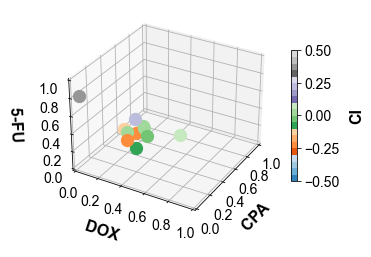

In [32]:
def plot_data(data, synergy, canvas):
  
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    parameters = {'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'font.family':'sans-serif',
              'font.sans-serif':['Arial']}
    plt.rcParams.update(parameters) 
    
    ax = plt.axes(projection='3d')
    cmap = plt.cm.tab20c
    norm = plt.Normalize(vmin=-0.5, vmax=0.5)

    
    for i in range(len(data.index)):
        x = data.iloc[i]['conc0']
        y = data.iloc[i]['conc1']
        z = data.iloc[i]['conc2']
        normalize = matplotlib.colors.Normalize(vmin=-0.5, vmax=0.5)
        
        if synergy:
            if not (np.isnan(data.iloc[i]['ci'])):
                col = data.iloc[i]['ci']
                p = ax.scatter3D(x, y, z, c=cmap(norm(col)), alpha = 1, s=150)
                
                               
        else:
            if data.iloc[i]['feas']:
                color = 'green'
            else:
                color = 'red'            
            if not(np.isnan(data.iloc[i]['ci'])):
                color = 'grey'
            ax.scatter3D(x, y, z, c=color, alpha = 0.5, s=150)
            
        

    ax.zaxis._axinfo['juggled'] = (1,2,0)
    ax.yaxis._axinfo['juggled'] = (0,1,2)
    #ax.set_title(title, fontsize=16)
    ax.xaxis._axinfo['label']['space_factor'] = 1

    ax.set_xlabel('DOX     ', fontsize=16,fontweight='bold', labelpad =10)
    ax.set_ylabel('CPA    ', fontsize=16,fontweight='bold', labelpad =10)
    ax.set_zlabel('5-FU    ', fontsize=16,fontweight='bold', labelpad =10)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.set_zlim(0,1)
    
    #ax.view_init(30, 45)
    #plt.draw()
    
    if synergy:
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.6, aspect=20)
        cbar.set_label("CI", fontsize=16, fontweight='bold', labelpad =10)
        title = title + '_syn'
    
    print('ok')
    
    figure_canvas_agg = FigureCanvasTkAgg(fig, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)

    return fig  

def load_data(name):
    data = pd.read_csv(name)
    return data

def load_fit(name):
    with open(name) as f:
        data = json.load(f)
    return data

#### show the output results as a table
def show_table(data , dilution, win_i):
    global rows_page
    global num_channels
    
    if dilution:
        headings =  ['index','x0', 'y0', 'Area','Int_gray','Int_live','Int_dead', 'Ratio','Viability','Row','Column','Device']
    
    headings =  ['DOX','CPA', '5-FU', 'CI', 'CV thoer']
    
    
    header =  [[sg.Text('  ')] + [sg.Text(h, size=(14,1)) for h in headings]]
    input_rows = []
    
    #### print the results from l to m number
    m = win_i*rows_page-1
    l = (win_i-1)*rows_page
    
    if m > len(stats): m = len(stats)
    
    
    for i in range(data)
    
    for i in range(l,m):
        row = []
        for j in range(len(stats.columns)):
            val = stats.iat[i,j]
            
            row.append(sg.Text(val, size=(14,1)))
        #row = [sg.Text(i, size=(14,1))]
        input_rows.append(row)
   
    buttons = [[sg.Button('Previous'), sg.Button('Next')], 
               [sg.Button('Save results'), sg.Button('Save images'),],
               [sg.Button('Analysis of images'), sg.Button('Main menu'), sg.Button('Quit')]]
    

    layout = header + input_rows + buttons
    return layout


name = 'experiments_oct1.csv'
fit_dict = load_fit('fit.json')
data_raw = load_data(name)

data = norm_data_inverse(data_raw,fit_dict)
data['cv_exp'] = cell_viability(data['conc0_inv'], data['conc1_inv'], data['conc2_inv'], fit_dict['fit'][0], fit_dict['fit'][1], fit_dict['fit'][2])

#feasibility threashold
data['feas'] = data['cv_exp']>0.5

layout = [[sg.Canvas(key='-CANVAS_SYN-',size=(50, 50))]]

window = sg.Window('', layout, finalize = True)

figure = plot_data(data, True, window['-CANVAS_SYN-'].TKCanvas)

while True:
    event, values = window.read()

    if event == 'Quit' or event == sg.WIN_CLOSED :
        window.close()
        cv2.destroyAllWindows()
name = 'experiments_oct1.csv'
fit_dict = load_fit('fit.json')
data_raw = load_data(name)

data = norm_data_inverse(data_raw,fit_dict)
data['cv_exp'] = cell_viability(data['conc0_inv'], data['conc1_inv'], data['conc2_inv'], fit_dict['fit'][0], fit_dict['fit'][1], fit_dict['fit'][2])

#feasibility threashold
data['feas'] = data['cv_exp']>0.5        break